In [37]:
import shap
from sklearn.impute import SimpleImputer
import xgboost as xgb
import numpy as np
import pandas as pd
import statsmodels.api as sm
import category_encoders as ce

from category_encoders import CountEncoder
from category_encoders import WOEEncoder
from category_encoders import HashingEncoder

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA


pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/ehambardzumy/Documents/big_data/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/ehambardzumy/Documents/big_data/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [3]:
def get_num_items(item):
    if not pd.isna(item):
        return len(item.split(","))
    else:
        item

In [4]:
def get_year(item):
    if not pd.isna(item):
        return int(str(item).split("-")[0])
    else:
        item

### Load data and Split

In [5]:
df_raw = pd.read_csv("train.csv")
df_raw = df_raw.set_index("property_id")
X_train, X_validation = train_test_split(df_raw, test_size=0.33, random_state=1982)
y_train = X_train.target

In [6]:
X_train['num_amenities'] = X_train['property_amenities'].apply(get_num_items)
X_train['n_verified_channels'] = X_train['host_verified'].apply(get_num_items)
X_train['host_since'] = X_train['host_since'].apply(get_year)
X_train['reviews_last'] = X_train['reviews_last'].apply(get_year)
X_train['reviews_first'] = X_train['reviews_first'].apply(get_year)

### Drop features

In [7]:
#coulumns with string values
cols_drop=['target',
           'property_sqfeet',
           'property_name',
           'property_summary',
           'property_space', 
           'property_desc',
           'property_neighborhood',
           'property_notes',
           'property_transit',
           'property_access',
           'property_interaction', 
           'property_rules', 
           'host_about',
           'host_response_time',
           'host_location',
           'host_id',
           'extra', 
           'host_verified',
           'property_amenities',
           'property_last_updated',
           'host_nr_listings_total',
           'property_zipcode',
           'property_scraped_at']

X_train=X_train.drop(columns=cols_drop)

### Proportion of missing data over total

In [8]:
X_train.dropna().shape[0],X_train.shape[0], X_train.dropna().shape[0]/X_train.shape[0]*100

(2867, 4351, 65.89289818432545)

In [9]:
X_train.isna().sum()

property_lat                  0
property_lon                  0
property_type                 0
property_room_type            0
property_max_guests           0
property_bathrooms           11
property_bedrooms             7
property_beds                 9
property_bed_type             0
host_since                    1
host_response_rate          982
host_nr_listings              1
booking_price_covers          0
booking_min_nights            0
booking_max_nights            0
booking_availability_30       0
booking_availability_60       0
booking_availability_90       0
booking_availability_365      0
booking_cancel_policy         0
reviews_num                   0
reviews_first               859
reviews_last                859
reviews_rating              923
reviews_acc                 935
reviews_cleanliness         933
reviews_checkin             937
reviews_communication       932
reviews_location            939
reviews_value               940
reviews_per_month           859
num_amen

### Average number of missing values for 'review' columns

In [10]:
np.mean(X_train[['reviews_first', 
         'reviews_last',
         "reviews_rating", 
         "reviews_rating",
         "reviews_acc", 
         "reviews_cleanliness", 
         "reviews_checkin", 
         "reviews_communication",
         "reviews_location",
         "reviews_value", 
         "reviews_per_month"]].isna().sum())

912.6363636363636

In [11]:
X_train[['reviews_first', 
         'reviews_last',
         "reviews_rating", 
         "reviews_rating",
         "reviews_acc", 
         "reviews_cleanliness", 
         "reviews_checkin", 
         "reviews_communication",
         "reviews_location",
         "reviews_value", 
         "reviews_per_month"]].describe()

,reviews_first,reviews_last,reviews_rating,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month
count,3492.000,3492.000,3428.000,3428.000,3416.000,3418.000,3414.000,3419.000,3412.000,3411.000,3492.000
mean,2015.499,2016.581,91.684,91.684,9.471,9.212,9.606,9.623,9.241,9.251,1.674
std,1.173,0.748,8.909,8.909,0.868,1.079,0.806,0.804,0.888,0.913,2.003
min,2010.000,2010.000,20.000,20.000,2.000,2.000,2.000,2.000,2.000,2.000,0.010
25%,2015.000,2016.000,89.000,89.000,9.000,9.000,9.000,9.000,9.000,9.000,0.310
50%,2016.000,2017.000,93.000,93.000,10.000,10.000,10.000,10.000,9.000,9.000,0.900
75%,2016.000,2017.000,98.000,98.000,10.000,10.000,10.000,10.000,10.000,10.000,2.262
max,2017.000,2017.000,100.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,14.250


### Impute with mode

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_columns = X_train.select_dtypes(include=numerics).columns 
non_numeric_cols = [col for col in X_train.columns if col not in numeric_columns]

In [14]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cols = X_train.columns
index = X_train.index
fitted_imputer = imp_mode.fit(X_train)
X_train = pd.DataFrame(fitted_imputer.transform(X_train))
X_train.columns = cols
X_train.index = index

In [16]:
np.sum(X_train.isna().sum())

0

In [17]:
X_train.dtypes

property_lat                object
property_lon                object
property_type               object
property_room_type          object
property_max_guests         object
property_bathrooms          object
property_bedrooms           object
property_beds               object
property_bed_type           object
host_since                  object
host_response_rate          object
host_nr_listings            object
booking_price_covers        object
booking_min_nights          object
booking_max_nights          object
booking_availability_30     object
booking_availability_60     object
booking_availability_90     object
booking_availability_365    object
booking_cancel_policy       object
reviews_num                 object
reviews_first               object
reviews_last                object
reviews_rating              object
reviews_acc                 object
reviews_cleanliness         object
reviews_checkin             object
reviews_communication       object
reviews_location    

In [18]:
X_train[numeric_columns] = X_train[numeric_columns].apply(pd.to_numeric)

In [19]:
X_train[['reviews_first', 
         'reviews_last',
         "reviews_rating", 
         "reviews_rating",
         "reviews_acc", 
         "reviews_cleanliness", 
         "reviews_checkin", 
         "reviews_communication",
         "reviews_location",
         "reviews_value", 
         "reviews_per_month"]].describe()

,reviews_first,reviews_last,reviews_rating,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month
count,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000
mean,2015.598,2016.664,93.448,93.448,9.585,9.381,9.691,9.704,9.405,9.413,1.541
std,1.069,0.690,8.608,8.608,0.799,1.010,0.732,0.729,0.846,0.865,1.814
min,2010.000,2010.000,20.000,20.000,2.000,2.000,2.000,2.000,2.000,2.000,0.010
25%,2015.000,2017.000,90.000,90.000,9.000,9.000,10.000,10.000,9.000,9.000,0.425
50%,2016.000,2017.000,96.000,96.000,10.000,10.000,10.000,10.000,10.000,10.000,1.000
75%,2016.000,2017.000,100.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,1.790
max,2017.000,2017.000,100.000,100.000,10.000,10.000,10.000,10.000,10.000,10.000,14.250


---

In [20]:
np.mean(sklearn_vif(numeric_columns, X_train)['VIF'])

4.171175746776163

In [21]:
sklearn_vif(numeric_columns, X_train)['VIF']

property_lat                1.606
property_lon                1.581
property_max_guests         3.779
property_bathrooms          1.251
property_bedrooms           1.938
property_beds               3.150
host_since                  1.330
host_response_rate          1.114
host_nr_listings            1.056
booking_price_covers        1.436
booking_min_nights          1.007
booking_max_nights          1.010
booking_availability_30    10.349
booking_availability_60    38.461
booking_availability_90    21.074
booking_availability_365    2.079
reviews_num                 2.994
reviews_first               2.334
reviews_last                1.459
reviews_rating              3.724
reviews_acc                 2.422
reviews_cleanliness         2.144
reviews_checkin             2.188
reviews_communication       2.323
reviews_location            1.565
reviews_value               2.845
reviews_per_month           2.504
num_amenities               1.158
n_verified_channels         1.084
Name: VIF, dty

In [22]:
availability_cols = ['booking_availability_30', 
                     'booking_availability_60', 
                     'booking_availability_90']

pca = PCA(n_components=1)
pca_fit = pca.fit(X_train[availability_cols])
X_train['availability'] = pca_fit.transform(X_train[availability_cols])

X_train.drop(availability_cols, axis=1, inplace=True)


In [23]:
pca_fit.explained_variance_ratio_

array([0.97479552])

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_columns = X_train.select_dtypes(include=numerics).columns 
non_numeric_cols = [col for col in X_train.columns if col not in numeric_columns]
np.mean(sklearn_vif(numeric_columns, X_train)['VIF'])

1.958627810754567

In [26]:
X_train[non_numeric_cols]

,property_type,property_room_type,property_bed_type,booking_cancel_policy
property_id,,,,
6315,Apartment,Entire home/apt,Real Bed,flexible
6077,Apartment,Entire home/apt,Real Bed,flexible
5869,House,Private room,Real Bed,flexible
3606,Apartment,Entire home/apt,Real Bed,flexible
1272,Apartment,Entire home/apt,Real Bed,moderate
...,...,...,...,...
4970,Apartment,Entire home/apt,Real Bed,moderate
2819,House,Private room,Real Bed,flexible
2803,Apartment,Entire home/apt,Real Bed,moderate


In [27]:
X_train = pd.get_dummies(X_train, columns=non_numeric_cols)

---

In [28]:
X_train.describe()

,property_lat,property_lon,property_max_guests,property_bathrooms,property_bedrooms,property_beds,host_since,host_response_rate,host_nr_listings,booking_price_covers,...,property_room_type_Shared room,property_bed_type_Airbed,property_bed_type_Couch,property_bed_type_Futon,property_bed_type_Pull-out Sofa,property_bed_type_Real Bed,booking_cancel_policy_flexible,booking_cancel_policy_moderate,booking_cancel_policy_strict,booking_cancel_policy_super_strict_30
count,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,...,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000,4351.000
mean,50.901,4.372,3.016,1.145,1.216,1.748,2014.245,93.624,6.020,1.435,...,0.013,0.001,0.003,0.006,0.023,0.968,0.424,0.306,0.270,0.000
std,0.141,0.032,1.770,0.455,0.748,1.303,1.458,17.649,35.506,0.954,...,0.114,0.026,0.057,0.074,0.149,0.176,0.494,0.461,0.444,0.015
min,50.769,4.268,1.000,0.000,0.000,1.000,2008.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,50.828,4.348,2.000,1.000,1.000,1.000,2013.000,100.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
50%,50.843,4.368,2.000,1.000,1.000,1.000,2014.000,100.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
75%,50.860,4.395,4.000,1.000,1.000,2.000,2015.000,100.000,2.000,2.000,...,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000
max,51.348,4.472,16.000,8.000,7.000,16.000,2017.000,100.000,591.000,16.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [29]:
X_train

,property_lat,property_lon,property_max_guests,property_bathrooms,property_bedrooms,property_beds,host_since,host_response_rate,host_nr_listings,booking_price_covers,...,property_room_type_Shared room,property_bed_type_Airbed,property_bed_type_Couch,property_bed_type_Futon,property_bed_type_Pull-out Sofa,property_bed_type_Real Bed,booking_cancel_policy_flexible,booking_cancel_policy_moderate,booking_cancel_policy_strict,booking_cancel_policy_super_strict_30
property_id,,,,,,,,,,,,,,,,,,,,,
6315,50.846,4.357,2,1.500,1.000,1.000,2016.000,100.000,3.000,1,...,0,0,0,0,0,1,1,0,0,0
6077,50.866,4.379,6,1.500,2.000,4.000,2016.000,97.000,2.000,3,...,0,0,0,0,0,1,1,0,0,0
5869,50.798,4.396,2,1.000,1.000,1.000,2016.000,100.000,1.000,1,...,0,0,0,0,0,1,1,0,0,0
3606,50.838,4.346,2,1.000,1.000,1.000,2015.000,70.000,1.000,1,...,0,0,0,0,0,1,1,0,0,0
1272,50.888,4.317,3,1.000,1.000,1.000,2014.000,100.000,4.000,2,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4970,50.849,4.356,2,1.000,1.000,1.000,2015.000,100.000,1.000,1,...,0,0,0,0,0,1,0,1,0,0
2819,51.214,4.428,2,1.000,1.000,1.000,2015.000,100.000,1.000,1,...,0,0,0,0,0,1,1,0,0,0
2803,50.844,4.356,4,1.000,0.000,4.000,2015.000,100.000,7.000,1,...,0,0,0,0,0,1,0,1,0,0


### XGBoost

In [34]:
regressor=xgb.XGBRegressor(eval_metric='rmse')

param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

In [35]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

model = regressor.fit(X_train, y_train)


In [38]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


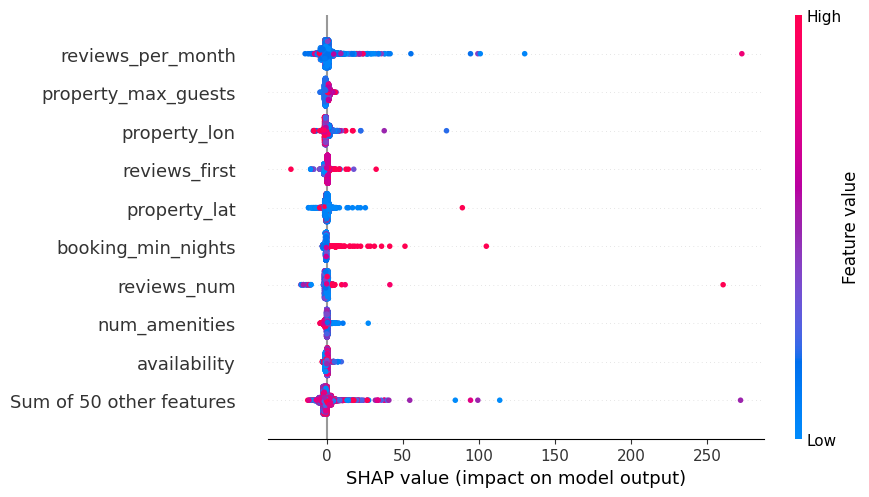

In [41]:
shap.plots.beeswarm(shap_values)

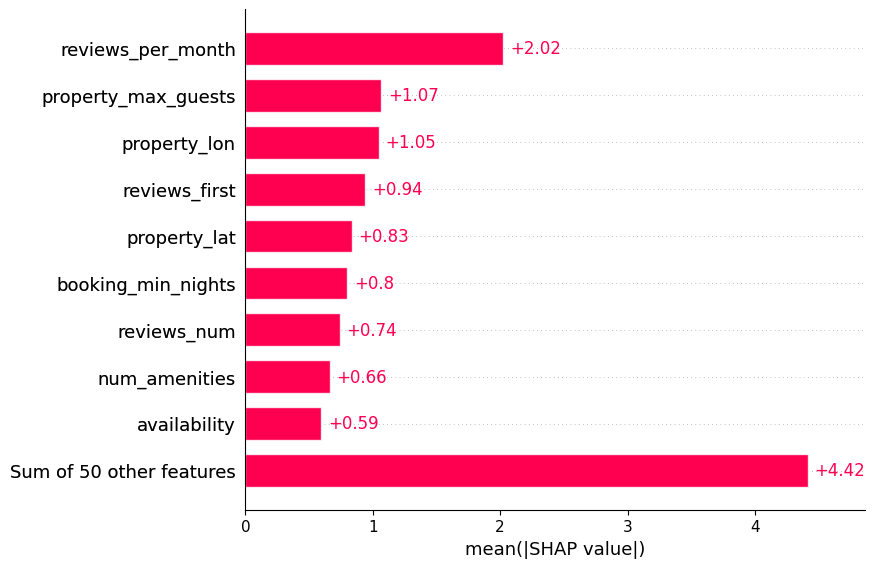

In [40]:
shap.plots.bar(shap_values)

In [54]:
scaler = preprocessing.MinMaxScaler().fit(X_train[numeric_columns])

In [55]:
X_scaled = pd.DataFrame(scaler.transform(X_train[numeric_columns]))
X_scaled.columns = numeric_columns
X_scaled.index = X_train.index 

In [56]:
X_train_new = pd.merge(X_train.drop(numeric_columns, axis=1), X_scaled, left_index=True, right_index=True)

In [57]:
model = regressor.fit(X_train_new, y_train)

In [58]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


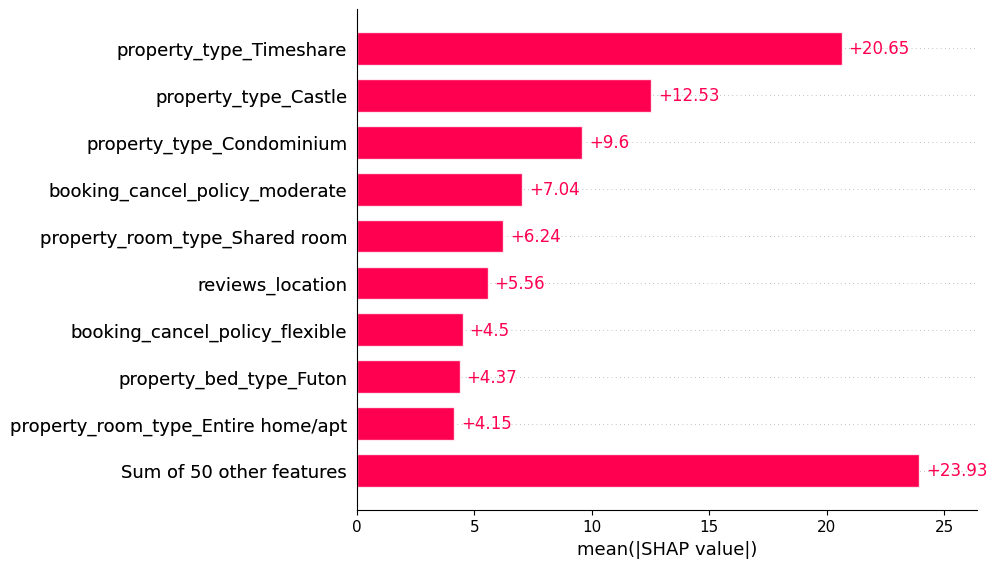

In [59]:
shap.plots.bar(shap_values)